In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import logging
import sys, os

from scipy.stats.mstats import winsorize
from scipy.stats import shapiro, mannwhitneyu, pointbiserialr

from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, make_scorer,
                             f1_score, roc_auc_score, auc, roc_curve, r2_score, mean_squared_error)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier          
from sklearn.pipeline import Pipeline    
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.feature_selection import mutual_info_classif

import shap
import pymc as pm
import arviz as az

import xgboost as xgb

from src.preprocessing import winsorize_columns
import backtest

/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Add src/ to the Python path
sys.path.append(os.path.join(os.getcwd(), "src"))
from main import preprocess
# Run the preprocessing pipeline and get final DataFrame
final_df = preprocess()
final_df.head()

/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Unnamed: 0.1,Unnamed: 0,date_x,symbol_fin,reportedCurrency_x,cik_x,fillingDate_x,acceptedDate,calendarYear_x,period_x,...,rnd_to_revenue_roll8,inventory_to_assets_roll4,inventory_to_assets_roll8,future_date,future_price,future_dji,log_dji_return,log_return_future,relative_log_return,good_stock
0,63111,75310,1999-12-31,DOX,USD,1062579.0,2000-01-05,2000-01-05,2000,Q1,...,0.063694,0.000000,0.000000,2000-06-08,58.586189,1461.670044,0.041601,0.715895,0.674294,1
1,130799,153831,1999-11-25,MCS,USD,62234.0,2000-01-07,2000-01-07,1999,Q4,...,0.000000,0.000000,0.000000,2000-04-07,4.356047,1516.349976,0.050643,-0.240857,-0.291499,0
2,141749,166758,1999-11-30,MTRX,USD,866273.0,2000-01-13,2000-01-13,2000,Q2,...,0.000000,0.035111,0.035111,2000-04-13,2.437500,1440.510010,-0.006346,-0.248461,-0.242116,0
3,188722,222772,1999-11-30,SKY,USD,90896.0,2000-01-13,2000-01-13,1999,Q3,...,0.000000,0.044463,0.044463,2000-08-04,13.072436,1462.930054,0.009098,-0.197612,-0.206711,0
4,196657,232068,1999-11-30,STRL,USD,874238.0,2000-01-14,2000-01-14,1999,Q4,...,0.000000,0.267070,0.267070,2000-07-19,1.187500,1481.959961,0.011408,-0.051293,-0.062701,0


In [3]:
# Additional ratios after netChangeInCash and netCashUsedProvidedByFinancingActivities were highlighted as important in the importance analysis
final_df['netChangeInCash_to_TotalAssets'] = final_df['netChangeInCash'] / final_df['totalAssets']
final_df['netChangeInCash_to_OpCashFlow'] = final_df['netChangeInCash'] / final_df['operatingCashFlow']
final_df['netChangeInCash_to_Revenue'] = final_df['netChangeInCash'] / final_df['revenue']

final_df['netCashFinancing_to_TotalDebt'] = final_df['netCashUsedProvidedByFinancingActivities'] / final_df['totalDebt']
final_df['netCashFinancing_to_Equity'] = final_df['netCashUsedProvidedByFinancingActivities'] / final_df['totalEquity']
final_df['netCashFinancing_to_OpCashFlow'] = final_df['netCashUsedProvidedByFinancingActivities'] / final_df['operatingCashFlow']
final_df['netCashFinancing_to_Revenue'] = final_df['netCashUsedProvidedByFinancingActivities'] / final_df['revenue']

Columns to check: ['netChangeInCash_to_TotalAssets', 'netChangeInCash_to_OpCashFlow', 'netChangeInCash_to_Revenue', 'netCashFinancing_to_TotalDebt', 'netCashFinancing_to_Equity', 'netCashFinancing_to_OpCashFlow', 'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables', 'otherCurrentAssets', 'totalCurrentAssets', 'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets', 'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets', 'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets', 'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables', 'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities', 'longTermDebt', 'deferredRevenueNonCurrent', 'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities', 'totalNonCurrentLiabilities', 'otherLiabilities', 'capitalLeaseObligations', 'totalLiabilities', 'preferredStock', 'commonStock', 'retainedEarnings', 'accumulatedOtherComprehensiveIncomeLoss', 'othertotalStockholdersEquity', 't

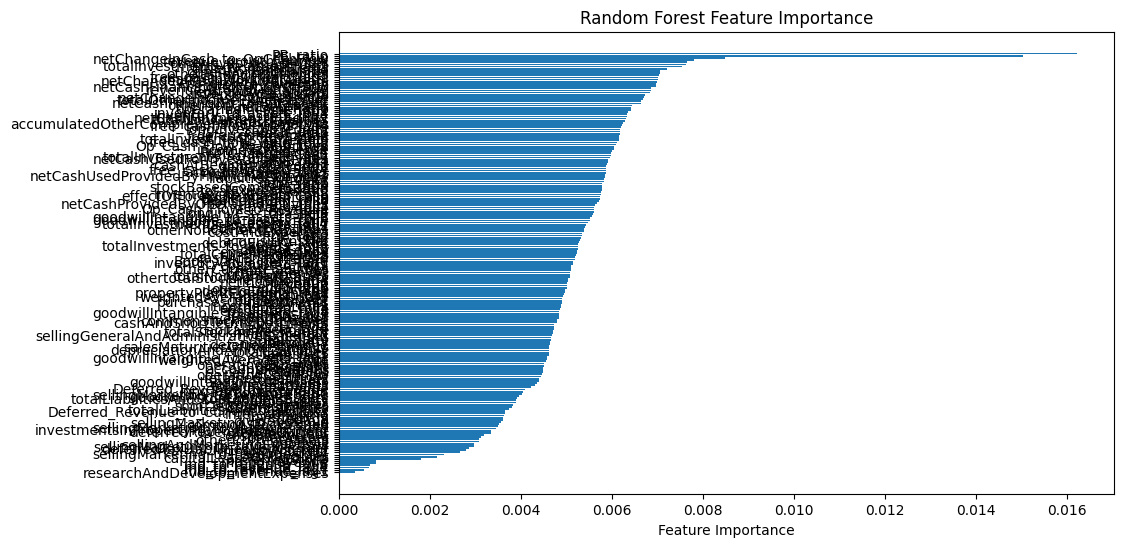

In [4]:
# Filter for the Financial Services sector and reset the index
fin_df = final_df[final_df['Sector'] == 'Financial Services'].reset_index(drop=True)

# Define the columns to check
columns_to_check = [
    'netChangeInCash_to_TotalAssets', 'netChangeInCash_to_OpCashFlow', 'netChangeInCash_to_Revenue', 
    'netCashFinancing_to_TotalDebt', 'netCashFinancing_to_Equity', 'netCashFinancing_to_OpCashFlow', 'netCashFinancing_to_Revenue'

    'cashAndCashEquivalents', 'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',  'otherCurrentAssets', 'totalCurrentAssets', 
     'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets', 'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets', 'otherNonCurrentAssets', 
     'totalNonCurrentAssets', 'otherAssets', 'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables', 'deferredRevenue', 'otherCurrentLiabilities', 
     'totalCurrentLiabilities', 'longTermDebt', 'deferredRevenueNonCurrent', 'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities', 'totalNonCurrentLiabilities', 
     'otherLiabilities', 'capitalLeaseObligations', 'totalLiabilities', 'preferredStock', 'commonStock', 'retainedEarnings', 'accumulatedOtherComprehensiveIncomeLoss', 
     'othertotalStockholdersEquity', 'totalStockholdersEquity', 'totalEquity', 'totalLiabilitiesAndStockholdersEquity', 'minorityInterest', 'totalLiabilitiesAndTotalEquity', 
     'totalInvestments', 'totalDebt', 'netDebt', 'revenue', 'costOfRevenue', 'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses', 
      'sellingAndMarketingExpenses', 'sellingGeneralAndAdministrativeExpenses', 'otherExpenses', 'operatingExpenses', 'costAndExpenses', 
     'interestIncome', 'interestExpense',  'ebitda', 'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio', 'totalOtherIncomeExpensesNet', 
     'incomeBeforeTax', 'incomeBeforeTaxRatio', 'incomeTaxExpense',  'netIncomeRatio', 'eps', 'epsdiluted', 'weightedAverageShsOut', 'weightedAverageShsOutDil', 
     'netIncome_y', 'depreciationAndAmortization_y', 'deferredIncomeTax', 'stockBasedCompensation', 'changeInWorkingCapital', 'accountsReceivables', 'inventory_y', 
     'accountsPayables', 'otherWorkingCapital', 'otherNonCashItems', 'netCashProvidedByOperatingActivities', 'investmentsInPropertyPlantAndEquipment', 'acquisitionsNet', 
     'purchasesOfInvestments', 'salesMaturitiesOfInvestments', 'otherInvestingActivites', 'netCashUsedForInvestingActivites', 'debtRepayment', 'commonStockIssued', 
     'commonStockRepurchased', 'dividendsPaid', 'otherFinancingActivites', 'netCashUsedProvidedByFinancingActivities', 'effectOfForexChangesOnCash', 'netChangeInCash', 
     'cashAtEndOfPeriod', 'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure', 'freeCashFlow', 
     
     'ROE', 'ROA', 'ROI', 'debtToEquity', 'netDebtRatio', 'debt_ratio', 
     'free_cash_flow_yield', 'Op_Cash_Flow_to_Revenue', 'Op_Cash_Flow_to_Liabilities', 'inventoryTurnover', 'inventory_to_assets', 'interest_coverage', 
     'longinvest_to_assets', 'longinvest_to_equity', 'totalInvestments_to_assets', 'Profit_Margin', 'retained_earnings', 're_ratio', 'currentRatio', 'cash_ratio', 'capital_light', 
     'liabilitiesToEquity', 'taxAssetsRatio', 'Deferred_Revenue_to_Revenue', 'Deferred_Revenue_to_Current_Liabilities', 'goodwillIntangible_to_assets', 'sellingMarketing_to_revenue', 
     'rnd_to_revenue', 'Book_Value_per_share', 'PE_ratio', 'PB_ratio', 'revenue_growth_quarterly', 'revenue_growth_annual', 'eps_growth_quarterly', 'eps_growth_annual', 
     'ROE_lag1', 'ROE_lag4', 'ROA_lag1', 'ROA_lag4', 'free_cash_flow_yield_lag1', 'free_cash_flow_yield_lag4', 're_ratio_lag1', 're_ratio_lag4', 
     'Profit_Margin_lag1', 'Profit_Margin_lag4', 'debtToEquity_lag1', 'debtToEquity_lag4', 'eps_lag1', 'eps_lag4', 'epsdiluted_lag1', 'epsdiluted_lag4', 
     'ebitda_lag1', 'ebitda_lag4', 'goodwillIntangible_to_assets_lag1', 'goodwillIntangible_to_assets_lag4', 'sellingMarketing_to_revenue_lag1', 'sellingMarketing_to_revenue_lag4', 
     'totalInvestments_to_assets_lag1', 'totalInvestments_to_assets_lag4', 'rnd_to_revenue_lag1', 'rnd_to_revenue_lag4', 'inventory_to_assets_lag1', 'inventory_to_assets_lag4', 
     'ROE_roll4', 'ROE_roll8', 'ROA_roll4', 'ROA_roll8', 'free_cash_flow_yield_roll4', 'free_cash_flow_yield_roll8', 're_ratio_roll4', 're_ratio_roll8', 
     'Profit_Margin_roll4', 'Profit_Margin_roll8', 'debtToEquity_roll4', 'debtToEquity_roll8', 'eps_roll4', 'eps_roll8', 'epsdiluted_roll4', 'epsdiluted_roll8', 
     'ebitda_roll4', 'ebitda_roll8', 'goodwillIntangible_to_assets_roll4', 'goodwillIntangible_to_assets_roll8', 
     'sellingMarketing_to_revenue_roll4', 'sellingMarketing_to_revenue_roll8', 'totalInvestments_to_assets_roll4', 'totalInvestments_to_assets_roll8', 
     'rnd_to_revenue_roll4', 'rnd_to_revenue_roll8', 'inventory_to_assets_roll4', 'inventory_to_assets_roll8']

# 'inventory_x', 'netIncome_x', 'depreciationAndAmortization_x', 'generalAndAdministrativeExpenses',


# Combine the selected columns with the target variable
existing_columns = [col for col in columns_to_check if col in fin_df.columns]
print("Columns to check:", existing_columns)

# Replace infinite values with NaN and then drop rows with NaN values
data_clean = fin_df[existing_columns + ['good_stock']].replace([np.inf, -np.inf], np.nan).dropna()

X_clean = data_clean[existing_columns]
y_clean = data_clean['good_stock']

print(f"Data shape after cleaning: {data_clean.shape}")


# Point-Biserial Correlation Analysis - linear relationships between each numeric feature and binary target
corr_dict = {}
for feature in existing_columns:
    try:
        corr, _ = pointbiserialr(y_clean, X_clean[feature])
        corr_dict[feature] = corr
    except Exception as e:
        print(f"Error computing correlation for feature '{feature}': {e}")

corr_df = pd.DataFrame(list(corr_dict.items()), columns=['Feature', 'PointBiserialCorrelation'])
corr_df = corr_df.sort_values(by='PointBiserialCorrelation', key=lambda x: np.abs(x), ascending=False)
print("\nTop features by Point-Biserial Correlation:")
print(corr_df.head(10))


# Mutual Information Analysis - captures non-linear relations
mi_scores = mutual_info_classif(X_clean, y_clean, random_state=42)
mi_df = pd.DataFrame({'Feature': existing_columns, 'MutualInfo': mi_scores})
mi_df = mi_df.sort_values(by='MutualInfo', ascending=False)
print("\nTop features by Mutual Information:")
print(mi_df.head(10))


# Random Forest Feature Importance
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

train_acc = rf.score(X_train, y_train)
test_acc = rf.score(X_test, y_test)
print(f"\nRandom Forest Training Accuracy: {train_acc:.2f}")
print(f"Random Forest Test Accuracy: {test_acc:.2f}")

fi = pd.DataFrame({'Feature': existing_columns, 'Importance': rf.feature_importances_})
fi = fi.sort_values(by='Importance', ascending=False)
print("\nTop features by Random Forest Importance:")
print(fi.head(10))

plt.figure(figsize=(10, 6))
plt.barh(fi['Feature'], fi['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis() 
plt.show()

In [5]:
# # Spearman correlations- point-biserial is more appropriate as it's designed for binary target variables

# # List the columns to ignore
# ignore_cols = [
#     'good_stock', 'calendarYear', 'calendarYear_y', 'calendarYear_x', 
#     'Adj Close', 'quarter_number', 'future_price', 
#     'cik_x', 'cik_y', 'cik', 'Unnamed: 0.1', 'Unnamed: 0',
#     'Return_future', 'relative_return', 'relative_log_return', 'log_return_future'  
# ]


# # fin_df = final_df[final_df['Sector'] == 'Financial Services']
# # Get unique sectors (doesn't matter here since it is just one sector)
# sectors = fin_df['Sector'].unique()

# # Dictionary to store Spearman correlations for each sector
# sector_spearman = {}

# # Set how many top features per sector to consider as votes
# top_n_per_sector = 30

# # FGilter the dataframe per sector
# for sector in sectors:
#     print(f"Processing sector: {sector}")
    
#     df_sector = fin_df[fin_df['Sector'] == sector].copy()

#     df_sector_numeric = df_sector.select_dtypes(include=['number'])
    
#     df_sector_numeric = df_sector_numeric.drop(columns=ignore_cols, errors='ignore')
    
#     # Ensure the 'good_stock' column is present 
#     if 'good_stock' not in df_sector.columns:
#         print(f"Skipping sector '{sector}': 'good_stock' column not found.")
#         continue
    
#     df_sector_numeric['good_stock'] = df_sector['good_stock']
    
#     spearman_corr = df_sector_numeric.corr(method='spearman')['good_stock'].drop('good_stock')
    
#     # Sort features by the absolute Spearman correlation (descending) and take the top N features
#     top_spearman = spearman_corr.abs().sort_values(ascending=False).head(top_n_per_sector)
#     sector_spearman[sector] = top_spearman
    
#     print("Top Spearman correlations with good_stock:")
#     print(top_spearman)
#     print("-" * 50)

# # Aggregate the top features (votes) across sectors and count how many times each feature appears in the top lists
# all_votes = []
# for sector, top_feats in sector_spearman.items():
#     all_votes.extend(top_feats.index.tolist())

# vote_counts = Counter(all_votes)
# vote_counts_df = pd.DataFrame.from_dict(vote_counts, orient='index', columns=['Votes'])
# vote_counts_df = vote_counts_df.sort_values(by='Votes', ascending=False)

# print("Aggregated Spearman vote counts across sectors:")
# print(vote_counts_df)

# vote_counts_df.plot(kind='bar', title='Aggregated Spearman Vote Counts Across Sectors', legend=False)
# plt.ylabel('Votes')
# plt.tight_layout()
# plt.show()

In [6]:
fin_df = final_df[final_df['Sector'] == 'Financial Services'].copy()
fin_df['accepted_date'] = pd.to_datetime(fin_df['accepted_date'])

# Time-based train/test split to avoid lookahead bias/leakage
# Sometimes, these type of models can end up remembering companies
train_cutoff = pd.Timestamp("2016-01-01")
test_cutoff_end = pd.Timestamp("2023-03-31")

train_df = fin_df[fin_df['accepted_date'] < train_cutoff].copy()
test_df  = fin_df[(fin_df['accepted_date'] >= train_cutoff) & (fin_df['accepted_date'] <= test_cutoff_end)].copy()

target = 'good_stock'
features = [
    'ROA', 'ROE', 'ROI',
    'revenue_growth_quarterly', 'revenue_growth_annual', 'Profit_Margin',
    'PB_ratio', 
    'Deferred_Revenue_to_Current_Liabilities', 'Deferred_Revenue_to_Revenue', 
    'cash_ratio', 'debt_ratio',
    'totalInvestments_to_assets',  
    'ROE_lag1', 
    'epsdiluted_lag1', 'epsdiluted_lag4', 
    'ROE_roll4', 'ROE_roll8', 'ROA_roll4', 'ROA_roll8',   
    'free_cash_flow_yield_roll8',
    'Profit_Margin_roll4',
    'epsdiluted',
    're_ratio_roll4',
    're_ratio_roll8',
    # 'netCashFinancing_to_TotalDebt', 
    # 'netChangeInCash_to_OpCashFlow'
]

# Replace infinities and drop missing values
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(subset=features + [target])
test_df = test_df.replace([np.inf, -np.inf], np.nan).dropna(subset=features + [target])

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


# As a model that predicts returns, a high accuracy (80-100%) is unlikely. In that case, the model is probably struggling
# with overfitting. The philosophy then would be to avoid bad investments. If we are creating a portfolio, the last thing
# we want to do is lose money. From there, the model should have a pool of stocks it considers healthy that it can then buy. 
def custom_recall_scorer(y_true, y_pred):
    """
    Computes the harmonic mean of recall for class 0 and class 1,
    but if recall for class 0 (not good) is less than 0.90, returns 0.
    This forces the grid search to favor models that have at least 90% recall for class 0.
    """
    recall0 = recall_score(y_true, y_pred, pos_label=0)
    recall1 = recall_score(y_true, y_pred, pos_label=1)
    if recall0 < 0.90:
        return 0.0
    if recall0 + recall1 == 0:
        return 0.0
    return 2 * (recall0 * recall1) / (recall0 + recall1)

custom_scorer = make_scorer(custom_recall_scorer, greater_is_better=True)

# Grid Search using the custom scorer
tscv = TimeSeriesSplit(n_splits=3)
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'max_features': [None, 'sqrt', 'log2']
# }

param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_split': [2],
    'max_features': [None]
}

rf_clf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid_rf,
                              scoring=custom_scorer,
                              cv=tscv,
                              verbose=1,
                              n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search_rf.best_params_)

best_rf_model = grid_search_rf.best_estimator_

# Model evaluation on the test set
y_pred = best_rf_model.predict(X_test)
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))

Train shape: (10141, 24)
Test shape: (8172, 24)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters found:
{'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.91      0.71      4763
           1       0.47      0.11      0.18      3409

    accuracy                           0.58      8172
   macro avg       0.53      0.51      0.45      8172
weighted avg       0.54      0.58      0.49      8172

Confusion Matrix:
[[4325  438]
 [3022  387]]
Accuracy: 0.5766030347528145
Precision: 0.4690909090909091
Recall: 0.11352302728072748
F1 Score: 0.18280585734529994
ROC AUC: 0.5242561356678518



Feature Importances:
cash_ratio                                 0.133686
epsdiluted_lag4                            0.120471
PB_ratio                                   0.067708
revenue_growth_annual                      0.066499
debt_ratio                                 0.057119
re_ratio_roll8                             0.054522
epsdiluted_lag1                            0.052447
totalInvestments_to_assets                 0.049729
epsdiluted                                 0.034573
Profit_Margin_roll4                        0.032723
ROI                                        0.031535
re_ratio_roll4                             0.030166
free_cash_flow_yield_roll8                 0.029536
ROE                                        0.028361
ROA_roll4                                  0.027741
revenue_growth_quarterly                   0.027413
ROA                                        0.026886
ROE_roll4                                  0.026699
ROE_lag1                                  

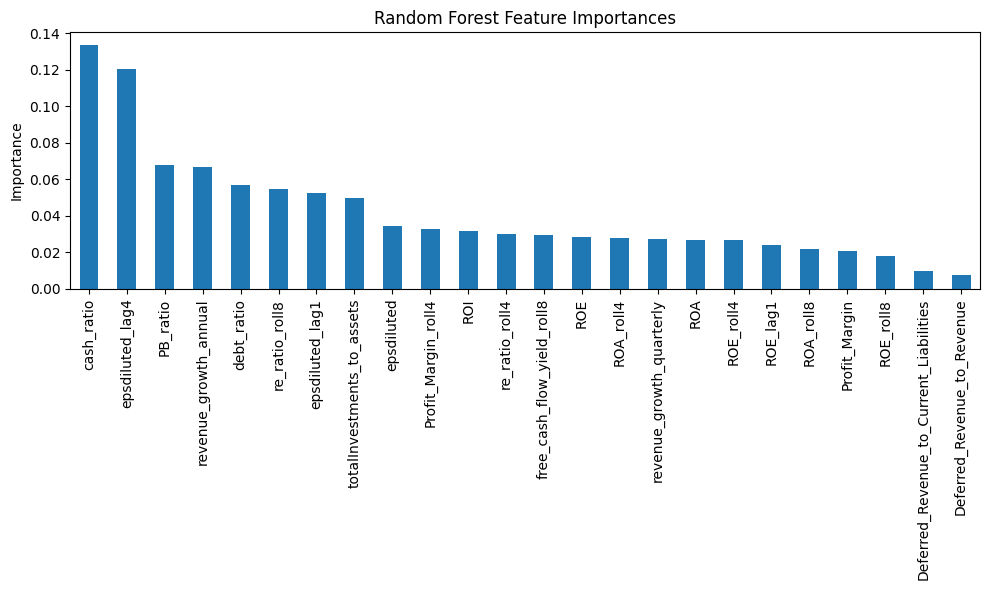

In [7]:
# Random Forests are extremely helpful in problems like this because of their ability to offer
# feature importances. In this case, we can see that cash ratio and EPS are the clear important features.
# This is reasonable as liquidity and earnings are extremely crucial in the Financial Services sector.
importances = best_rf_model.feature_importances_
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Valid Trades Summary (first few rows):
  symbol_stock          entry_date           exit_date  trade_return  \
0         ACGL 2016-02-26 17:38:12 2016-05-06 15:05:48      0.017232   
1         ACGL 2019-02-28 16:14:41 2019-08-07 11:57:11      0.187714   
2         ACGL 2020-02-28 17:07:41 2020-05-08 16:13:14     -0.372150   
3         ACGL 2021-05-06 14:43:28 2021-08-05 14:41:29     -0.008468   
4          AGM 2022-05-09 16:13:40 2022-08-08 16:13:00      0.047393   

   position_size  hold_periods            exit_reason Quarter  
0     925.193736             2          signal_change  2016Q2  
1     643.793683             3          signal_change  2019Q3  
2     520.226023             2  stop_loss/take_profit  2020Q2  
3     528.859408             2          signal_change  2021Q3  
4     208.114351             2    fundamentals_change  2022Q3  

Enhanced Trade-Level Backtest Performance:
Quarterly Trade Returns:
 2016Q1   -0.010000
2016Q2    0.050593
2016Q3    0.076730
2016Q4    0.14639

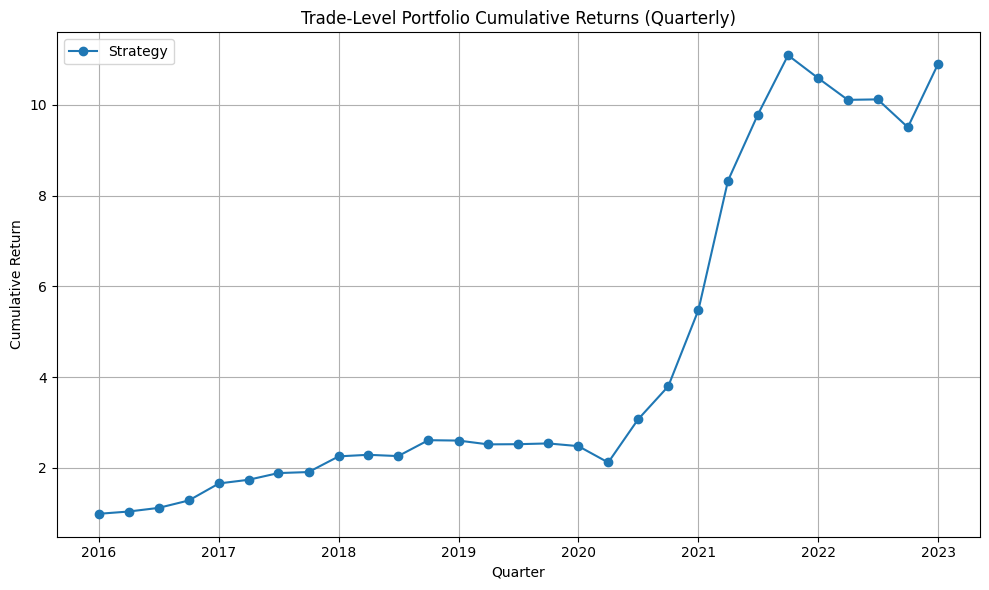

In [8]:
# To hold a more realistic portfolio, we use the enhanced backtest to account for holding a stock until the signal changes - 
# either due to a negative return, a deterioration of fundamentals, or a threshold for profit/loss. 

# Enhanced Backtest

transaction_cost = 0.005  # 0.5% per trade side
slippage = 0.002          # 0.2% slippage per trade side

# Add predictions to test_df
predicted_signal = best_rf_model.predict(X_test)
test_df.loc[X_test.index, 'predicted_signal'] = predicted_signal

test_sim = test_df.sort_values(['symbol_stock', 'accepted_date']).copy()

# Select simulation function

# simulation_function = backtest.simulate_trades_for_stock_baseline
simulation_function = backtest.simulate_trades_for_stock_enhanced

all_trades = []
for symbol, group in test_sim.groupby('symbol_stock'):
    trades = simulation_function(group, transaction_cost, slippage,
                                 stop_loss=-0.05, take_profit=1.0,
                                 max_hold_periods=20, risk_per_trade=1000, account_balance=100000)
    all_trades.extend(trades)

trades_df = pd.DataFrame(all_trades)

if not trades_df.empty:
    trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
    trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])
    trades_df['Quarter'] = trades_df['exit_date'].dt.to_period('Q')
    
    # Exclude trades that were force-closed immediately (no holding period).
    valid_trades_df = trades_df[trades_df['entry_date'] < trades_df['exit_date']]
    
    print("Valid Trades Summary (first few rows):")
    print(valid_trades_df.head())
    
    quarterly_trade_returns = valid_trades_df.groupby('Quarter')['trade_return'].mean()
    all_quarters = pd.period_range(start=test_sim['accepted_date'].min().to_period('Q'),
                                   end=test_sim['accepted_date'].max().to_period('Q'),
                                   freq='Q')
    quarterly_trade_returns = quarterly_trade_returns.reindex(all_quarters, fill_value=-0.01)
    
    cumulative_returns = (1 + quarterly_trade_returns).cumprod()
    n_quarters = len(cumulative_returns)
    observed_annualized_return = (cumulative_returns.iloc[-1]) ** (4 / n_quarters) - 1
    sharpe_ratio = quarterly_trade_returns.mean() / quarterly_trade_returns.std() * np.sqrt(4)
    
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    print("\nEnhanced Trade-Level Backtest Performance:")
    print("Quarterly Trade Returns:\n", quarterly_trade_returns)
    print("Cumulative Portfolio Returns:\n", cumulative_returns)
    print(f"Observed Annualized Return: {observed_annualized_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns.index.to_timestamp(), cumulative_returns, marker='o', label='Strategy')
    plt.title("Trade-Level Portfolio Cumulative Returns (Quarterly)")
    plt.xlabel("Quarter")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No trades were generated from the simulation.")

In [9]:
# for feat in features:
#     plt.figure(figsize=(8, 4))
#     sns.boxplot(x=train_df[feat])
#     plt.title(f"Boxplot of {feat}")
#     plt.show()
    
#     plt.figure(figsize=(8, 4))
#     plt.hist(train_df[feat], bins=50)
#     plt.title(f"Histogram of {feat}")
#     plt.xlabel(feat)
#     plt.ylabel("Frequency")
#     plt.show()

In [10]:
print(train_df[features].describe())

                ROA           ROE           ROI  revenue_growth_quarterly  \
count  10141.000000  10141.000000  1.014100e+04              1.014100e+04   
mean       0.007857      0.025374  1.912265e+04              1.982517e+02   
std        0.120294      0.779096  1.380531e+06              1.409141e+04   
min       -0.724287    -39.769046 -7.463846e+05             -2.004140e+02   
25%        0.001793      0.015264  4.124954e-03             -3.113826e-02   
50%        0.003143      0.027064  9.681293e-03              1.511329e-02   
75%        0.007321      0.039969  2.199427e-02              6.656082e-02   
max       11.183356     48.388281  1.067591e+08              1.107871e+06   

       revenue_growth_annual  Profit_Margin       PB_ratio  \
count           1.014100e+04   10141.000000   10141.000000   
mean            2.961876e+02       0.174121      31.184359   
std             2.204970e+04       5.768783    2945.254502   
min            -2.239167e+02    -207.747686    -575.166802

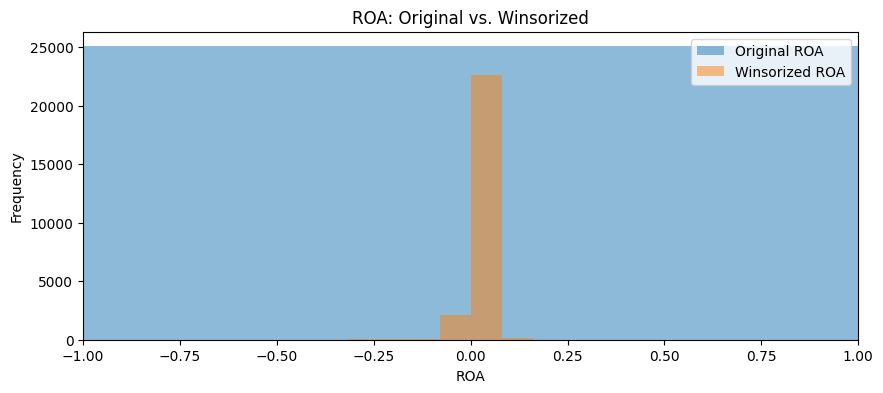

ROA - Original summary:
count    25065.000000
mean         0.019580
std          1.670036
min        -29.574964
25%          0.001877
50%          0.003175
75%          0.007970
max        190.190769
Name: ROA, dtype: float64

ROA - Winsorized summary:
count    25065.000000
mean         0.005954
std          0.056987
min         -2.000000
25%          0.001877
50%          0.003175
75%          0.007970
max          2.000000
Name: ROA_win, dtype: float64


In [11]:
### Winsorization

fin_df = final_df[final_df['Sector'] == 'Financial Services'].copy()

fin_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define columns for winsorization

# 1. Fixed-limit winsorization columns: return/efficiency ratios
fixed_limit_cols = [
    'ROA', 'ROE', 'ROI', 'ROE_lag1', 'ROE_roll4', 'ROE_roll8',
    'ROA_roll4', 'ROA_roll8', 'Profit_Margin', 'Profit_Margin_roll4',
    're_ratio_roll4', 're_ratio_roll8' 
]

# 2. EPS-related features
eps_cols = ['epsdiluted', 'epsdiluted_lag1', 'epsdiluted_lag4']

# 3. Valuation and liquidity measures (add to fixed_limit_cols)
fixed_limit_cols.extend(['PB_ratio', 'cash_ratio', 'free_cash_flow_yield_roll8'])

# 4. Quantile-based winsorization columns: growth and investments
quantile_cols = ['revenue_growth_quarterly', 'revenue_growth_annual', 'totalInvestments_to_assets']

# 5. Columns to be left untouched
untouched_cols = ['debt_ratio']

# Set fixed limits for the fixed limit columns
fixed_limits = {
    # Return and efficiency ratios
    'ROA': (-2, 2),
    'ROE': (-2, 2),
    'ROI': (-2, 2),
    'ROE_lag1': (-2, 2),
    'ROE_roll4': (-2, 2),
    'ROE_roll8': (-2, 2),
    'ROA_roll4': (-2, 2),
    'ROA_roll8': (-2, 2),
    'Profit_Margin': (-2, 2),
    'Profit_Margin_roll4': (-2, 2),
    # Valuation and liquidity measures
    'PB_ratio': (0, 10),
    'cash_ratio': (0, 20),
    'free_cash_flow_yield_roll8': (-5, 5),
    # EPS related features
    'epsdiluted': (0, 20),
    'epsdiluted_lag1': (0, 20),
    'epsdiluted_lag4': (0, 20),
    #
    're_ratio_roll4': (-2, 2), 
    're_ratio_roll8': (-2, 2)
}

# Define Winsorization functions
def winsorize_fixed(series, lower, upper):
    """Clip series values to the fixed [lower, upper] range."""
    return series.clip(lower, upper)

def winsorize_quantile(series, lower_quantile=0.05, upper_quantile=0.95):
    """Clip series values to the range defined by the quantiles."""
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower_bound, upper_bound)


# 1. Fixed-limit winsorization for fixed_limit_cols and eps_cols
for col in fixed_limit_cols + eps_cols:
    if col in fin_df.columns:
        lower, upper = fixed_limits[col]
        fin_df[col + '_win'] = winsorize_fixed(fin_df[col], lower, upper)

# 2. Quantile-based winsorization for growth/investment metrics
for col in quantile_cols:
    if col in fin_df.columns:
        fin_df[col + '_win'] = winsorize_quantile(fin_df[col])

# 3. Columns to be left untouched are copied
for col in untouched_cols:
    if col in fin_df.columns:
        fin_df[col + '_win'] = fin_df[col]

# Visualization and summary for a selected feature
valid_ROA = fin_df['ROA'][np.isfinite(fin_df['ROA'])].dropna()
valid_ROA_win = fin_df['ROA_win'][np.isfinite(fin_df['ROA_win'])].dropna()

plt.figure(figsize=(10, 4))
plt.hist(valid_ROA, bins=50, alpha=0.5, label='Original ROA')
plt.hist(valid_ROA_win, bins=50, alpha=0.5, label='Winsorized ROA')
plt.title('ROA: Original vs. Winsorized')
plt.xlabel('ROA')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.show()

print("ROA - Original summary:")
print(valid_ROA.describe())
print("\nROA - Winsorized summary:")
print(valid_ROA_win.describe())

Train shape: (10141, 21)
Test shape: (8172, 21)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters found:
{'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.91      0.72      4763
           1       0.48      0.12      0.19      3409

    accuracy                           0.58      8172
   macro avg       0.53      0.51      0.45      8172
weighted avg       0.54      0.58      0.50      8172

Confusion Matrix:
[[4327  436]
 [3011  398]]
Accuracy: 0.5781938325991189
Precision: 0.47721822541966424
Recall: 0.11674977999413318
F1 Score: 0.18760311100636343
ROC AUC: 0.5215682733833642

Feature Importances:
epsdiluted_lag4_win               0.122157
cash_ratio_win                    0.121750
PB_ratio_win                      0.076424
revenue_growth_annual_win         0.065486
debt_ratio_win                    0.064697
totalIn

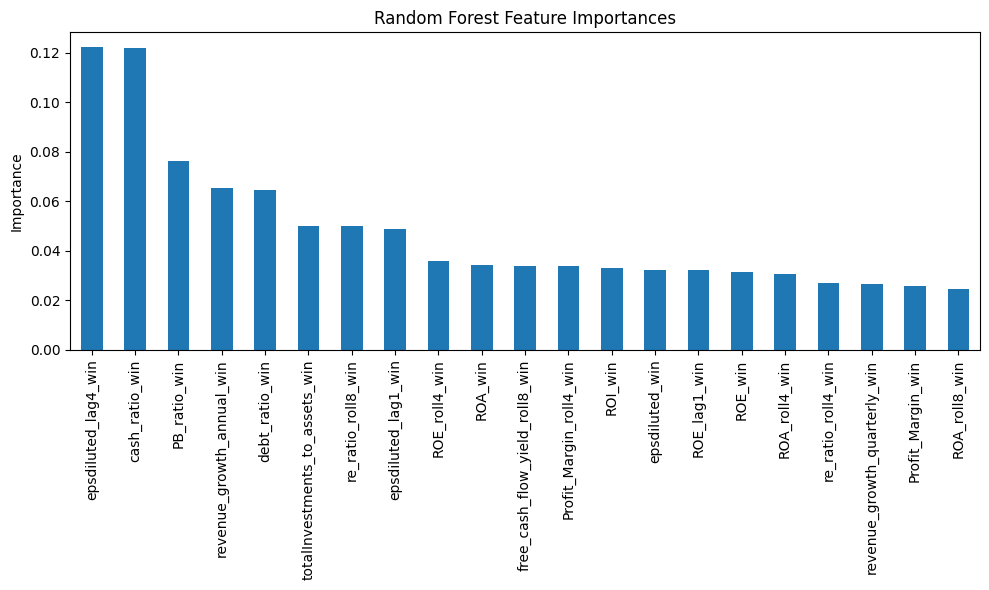

In [12]:
# fin_df = final_df[final_df['Sector'] == 'Financial Services']
fin_df['accepted_date'] = pd.to_datetime(fin_df['accepted_date'])

# Time-based train/test split to make sure there is no data leakage
train_cutoff = pd.Timestamp("2016-01-01")
# train_cutoff = pd.Timestamp("2011-01-01")
# test_cutoff_end = pd.Timestamp("2023-06-30")
test_cutoff_end = pd.Timestamp("2023-03-31")

train_df = fin_df[fin_df['accepted_date'] < train_cutoff].copy()
test_df  = fin_df[(fin_df['accepted_date'] >= train_cutoff) & 
                  (fin_df['accepted_date'] <= test_cutoff_end)].copy()

# Define target and features
target = 'good_stock'

features = [
    'ROA_win', 'ROE_win', 'ROI_win', 'ROE_lag1_win', 'ROE_roll4_win', 
    # 'ROE_roll8_win', 
    'ROA_roll4_win', 'ROA_roll8_win',
    'Profit_Margin_win', 'Profit_Margin_roll4_win',
    'PB_ratio_win',
    'cash_ratio_win',
    'free_cash_flow_yield_roll8_win',
    'epsdiluted_win', 'epsdiluted_lag1_win', 'epsdiluted_lag4_win',
    'revenue_growth_quarterly_win', 'revenue_growth_annual_win',
    'totalInvestments_to_assets_win',
    'debt_ratio_win',

    're_ratio_roll4_win',
    're_ratio_roll8_win',
]


# Replace infinite values with NaN and drop rows with missing values, NAN, in the training and testing dataframes
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.replace([np.inf, -np.inf], np.nan)

train_df = train_df.dropna(subset=features + [target])
test_df = test_df.dropna(subset=features + [target])

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]


print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Time series cross-validation and grid search
tscv = TimeSeriesSplit(n_splits=3)
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_split': [2],
    'max_features': [None]
}

rf_clf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid_rf,
                              scoring='roc_auc',
                              cv=tscv,
                              verbose=1,
                              n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search_rf.best_params_)

best_rf_model = grid_search_rf.best_estimator_

# Model evaluation on test set
y_pred = best_rf_model.predict(X_test)
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))

# Feature importance
importances = best_rf_model.feature_importances_
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Valid Trades Summary (first few rows):
  symbol_stock          entry_date           exit_date  trade_return  \
0           AB 2018-02-13 07:02:10 2019-02-13 07:17:51      0.279085   
1         ABCB 2016-08-09 16:11:11 2016-11-09 17:26:37      0.140569   
2         ACGL 2016-11-04 12:43:38 2017-03-01 15:50:14      0.226347   
3         ACGL 2019-02-28 16:14:41 2019-08-07 11:57:11      0.187714   
4         ACGL 2020-02-28 17:07:41 2020-05-08 16:13:14     -0.372150   

   position_size  hold_periods            exit_reason Quarter  
0    1394.143731             2          signal_change  2019Q1  
1     662.248293             2          signal_change  2016Q4  
2     817.546193             2          signal_change  2017Q1  
3     643.793683             3          signal_change  2019Q3  
4     520.226023             2  stop_loss/take_profit  2020Q2  

Enhanced Trade-Level Backtest Performance:
Quarterly Trade Returns:
 2016Q1   -0.010000
2016Q2    0.072531
2016Q3    0.082716
2016Q4    0.00990

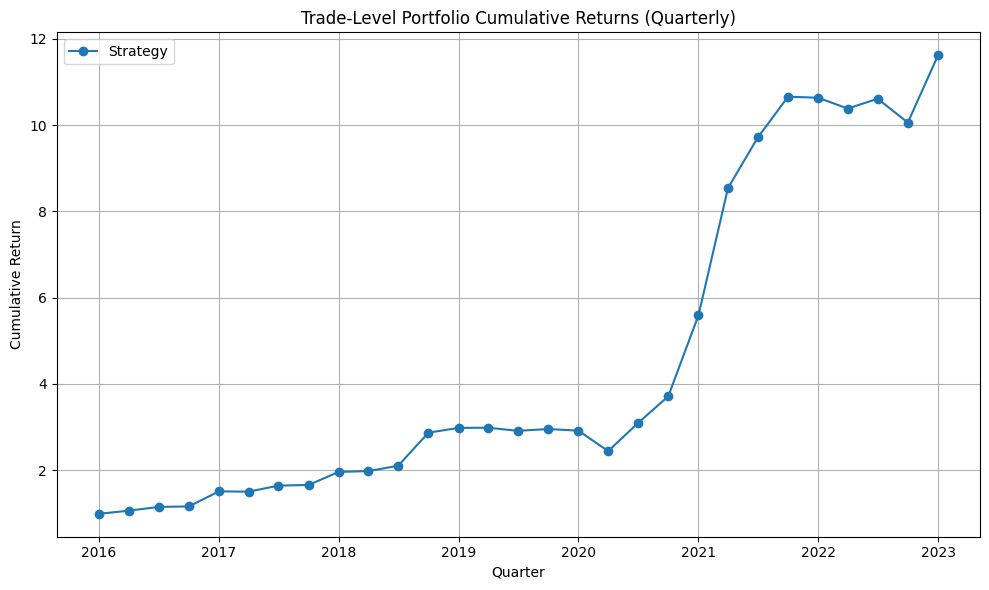

In [13]:
# To hold a more realistic portfolio, we use the enhanced backtest to account for holding a stock until the signal changes - 
# either due to a negative return, a deterioration of fundamentals, or a threshold for profit/loss. 

# Enhanced Backtest

transaction_cost = 0.005  # 0.5% per trade side
slippage = 0.002          # 0.2% slippage per trade side

# Add predictions to test_df
predicted_signal = best_rf_model.predict(X_test)
test_df.loc[X_test.index, 'predicted_signal'] = predicted_signal

test_sim = test_df.sort_values(['symbol_stock', 'accepted_date']).copy()

# Select simulation function

# simulation_function = backtest.simulate_trades_for_stock_baseline
simulation_function = backtest.simulate_trades_for_stock_enhanced

all_trades = []
for symbol, group in test_sim.groupby('symbol_stock'):
    trades = simulation_function(group, transaction_cost, slippage,
                                 stop_loss=-0.05, take_profit=1.0,
                                 max_hold_periods=20, risk_per_trade=1000, account_balance=100000)
    all_trades.extend(trades)

trades_df = pd.DataFrame(all_trades)

if not trades_df.empty:
    trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
    trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])
    trades_df['Quarter'] = trades_df['exit_date'].dt.to_period('Q')
    
    # Exclude trades that were force-closed immediately (no holding period).
    valid_trades_df = trades_df[trades_df['entry_date'] < trades_df['exit_date']]
    
    print("Valid Trades Summary (first few rows):")
    print(valid_trades_df.head())
    
    quarterly_trade_returns = valid_trades_df.groupby('Quarter')['trade_return'].mean()
    all_quarters = pd.period_range(start=test_sim['accepted_date'].min().to_period('Q'),
                                   end=test_sim['accepted_date'].max().to_period('Q'),
                                   freq='Q')
    quarterly_trade_returns = quarterly_trade_returns.reindex(all_quarters, fill_value=-0.01)
    
    cumulative_returns = (1 + quarterly_trade_returns).cumprod()
    n_quarters = len(cumulative_returns)
    observed_annualized_return = (cumulative_returns.iloc[-1]) ** (4 / n_quarters) - 1
    sharpe_ratio = quarterly_trade_returns.mean() / quarterly_trade_returns.std() * np.sqrt(4)
    
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    print("\nEnhanced Trade-Level Backtest Performance:")
    print("Quarterly Trade Returns:\n", quarterly_trade_returns)
    print("Cumulative Portfolio Returns:\n", cumulative_returns)
    print(f"Observed Annualized Return: {observed_annualized_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns.index.to_timestamp(), cumulative_returns, marker='o', label='Strategy')
    plt.title("Trade-Level Portfolio Cumulative Returns (Quarterly)")
    plt.xlabel("Quarter")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No trades were generated from the simulation.")


Feature: relative_log_return

True Positives Stats:
count    398.000000
mean       0.148440
std        0.145648
min        0.021436
25%        0.061710
50%        0.107814
75%        0.178844
max        1.595366
Name: relative_log_return, dtype: float64

False Positives Stats:
count    436.000000
mean      -0.115101
std        0.154463
min       -1.158748
25%       -0.147042
50%       -0.068419
75%       -0.022482
max        0.019351
Name: relative_log_return, dtype: float64

True Negatives Stats:
count    4327.000000
mean       -0.107659
std         0.140369
min        -1.953188
25%        -0.145801
50%        -0.069028
75%        -0.021715
max         0.019792
Name: relative_log_return, dtype: float64

False Negatives Stats:
count    3011.000000
mean        0.126761
std         0.137824
min         0.019852
25%         0.050121
50%         0.091852
75%         0.161240
max         2.700460
Name: relative_log_return, dtype: float64


<Figure size 1200x600 with 0 Axes>

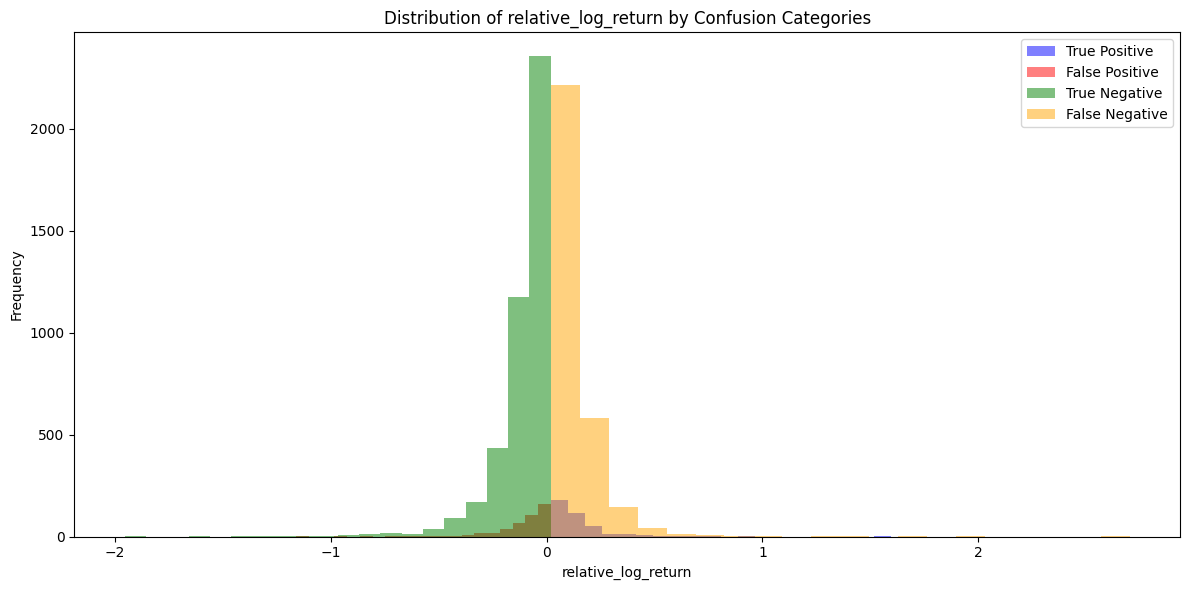


Feature: ROE_win

True Positives Stats:
count    398.000000
mean       0.067209
std        0.192987
min       -1.038818
25%        0.022826
50%        0.038805
75%        0.082796
max        2.000000
Name: ROE_win, dtype: float64

False Positives Stats:
count    436.000000
mean       0.078242
std        0.238040
min       -2.000000
25%        0.018776
50%        0.036772
75%        0.072381
max        2.000000
Name: ROE_win, dtype: float64

True Negatives Stats:
count    4327.000000
mean        0.020401
std         0.115952
min        -2.000000
25%         0.014939
50%         0.025388
75%         0.036261
max         2.000000
Name: ROE_win, dtype: float64

False Negatives Stats:
count    3011.000000
mean        0.025828
std         0.102152
min        -2.000000
25%         0.014928
50%         0.025921
75%         0.038292
max         2.000000
Name: ROE_win, dtype: float64


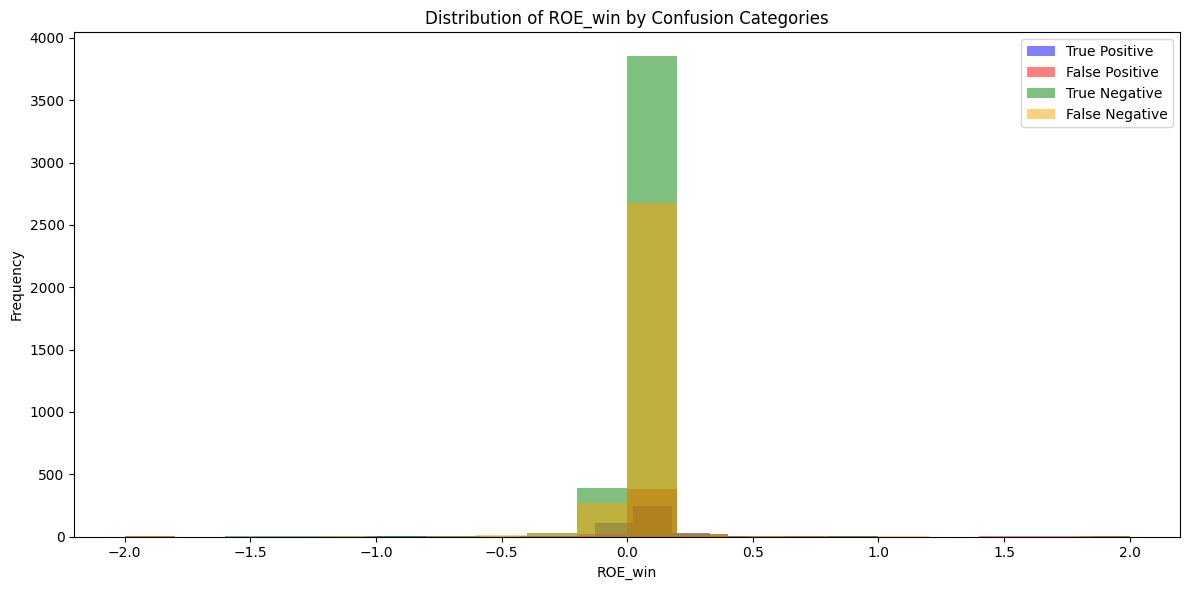


Feature: ROA_win

True Positives Stats:
count    398.000000
mean       0.016221
std        0.045469
min       -0.769536
25%        0.003919
50%        0.011714
75%        0.025846
max        0.150110
Name: ROA_win, dtype: float64

False Positives Stats:
count    436.000000
mean       0.004386
std        0.098849
min       -1.110138
25%        0.002782
50%        0.008634
75%        0.021358
max        0.267782
Name: ROA_win, dtype: float64

True Negatives Stats:
count    4327.000000
mean        0.003901
std         0.038831
min        -1.081688
25%         0.001962
50%         0.003148
75%         0.006216
max         0.302089
Name: ROA_win, dtype: float64

False Negatives Stats:
count    3011.000000
mean        0.006333
std         0.022068
min        -0.414542
25%         0.002022
50%         0.003240
75%         0.008430
max         0.269948
Name: ROA_win, dtype: float64


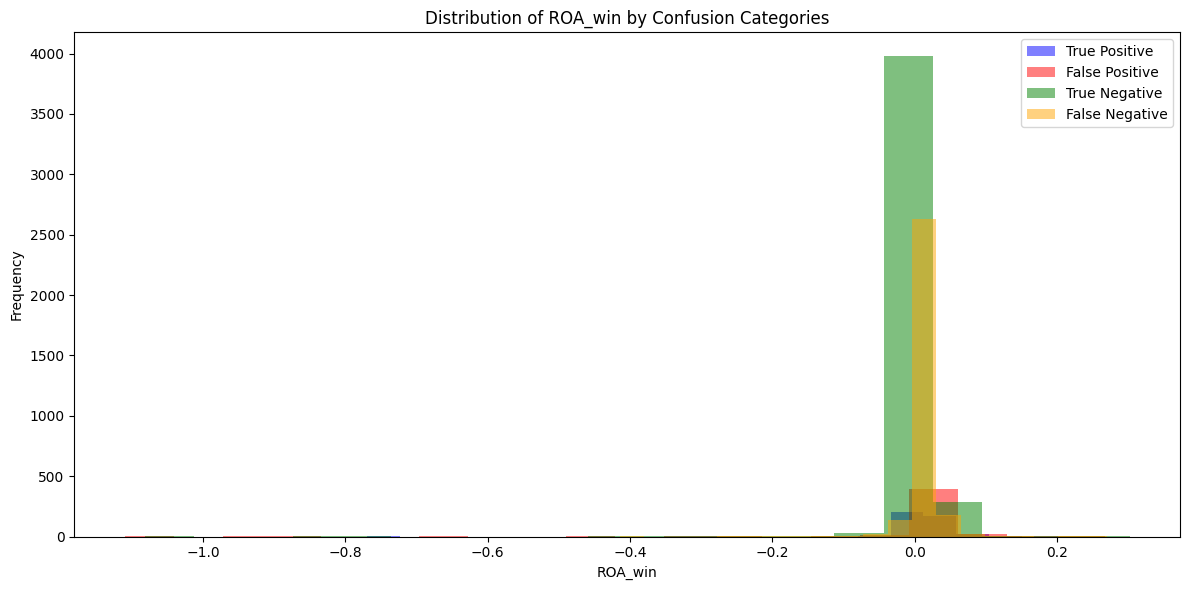


Feature: revenue_growth_quarterly_win

True Positives Stats:
count    398.000000
mean       0.073325
std        0.173186
min       -0.291212
25%       -0.016268
50%        0.041426
75%        0.147236
max        0.432460
Name: revenue_growth_quarterly_win, dtype: float64

False Positives Stats:
count    436.000000
mean       0.054056
std        0.170334
min       -0.291212
25%       -0.028226
50%        0.031551
75%        0.120771
max        0.432460
Name: revenue_growth_quarterly_win, dtype: float64

True Negatives Stats:
count    4327.000000
mean        0.021221
std         0.150413
min        -0.291212
25%        -0.035322
50%         0.012209
75%         0.062316
max         0.432460
Name: revenue_growth_quarterly_win, dtype: float64

False Negatives Stats:
count    3011.000000
mean        0.024810
std         0.149496
min        -0.291212
25%        -0.031628
50%         0.016814
75%         0.067719
max         0.432460
Name: revenue_growth_quarterly_win, dtype: float64


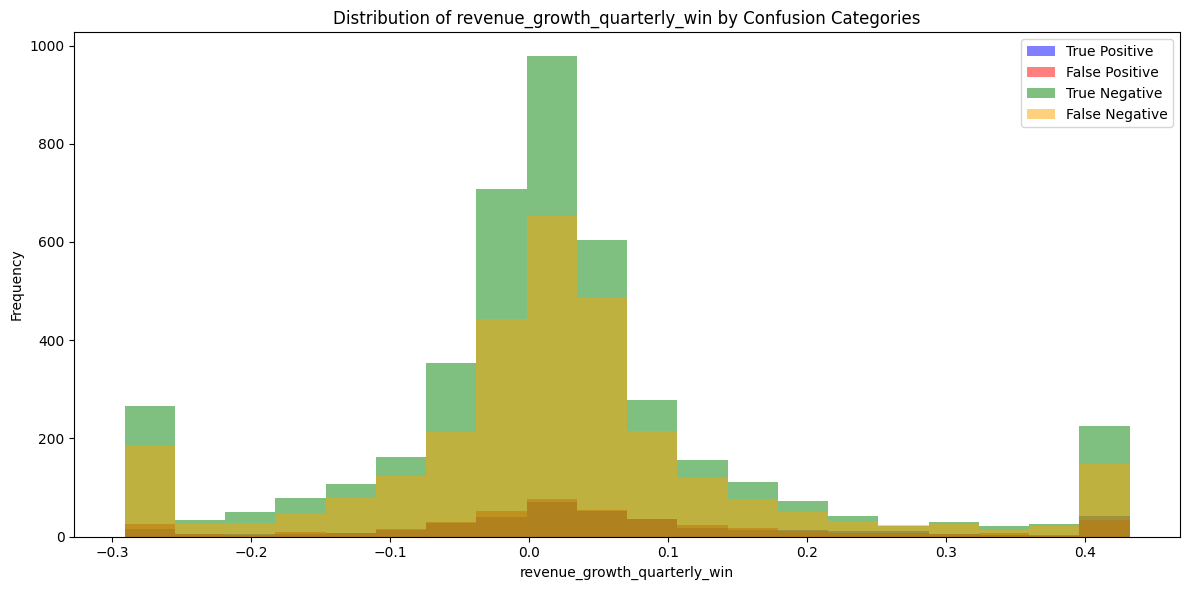


Feature: PB_ratio_win

True Positives Stats:
count    398.000000
mean       3.073216
std        3.312665
min        0.000000
25%        0.786806
50%        1.446790
75%        4.395484
max       10.000000
Name: PB_ratio_win, dtype: float64

False Positives Stats:
count    436.000000
mean       2.761249
std        3.152545
min        0.000000
25%        0.668687
50%        1.327263
75%        3.432709
max       10.000000
Name: PB_ratio_win, dtype: float64

True Negatives Stats:
count    4327.000000
mean        1.743841
std         2.048231
min         0.000000
25%         0.770990
50%         1.124464
75%         1.674778
max        10.000000
Name: PB_ratio_win, dtype: float64

False Negatives Stats:
count    3011.000000
mean        1.800236
std         2.074259
min         0.000000
25%         0.748321
50%         1.092600
75%         1.783189
max        10.000000
Name: PB_ratio_win, dtype: float64


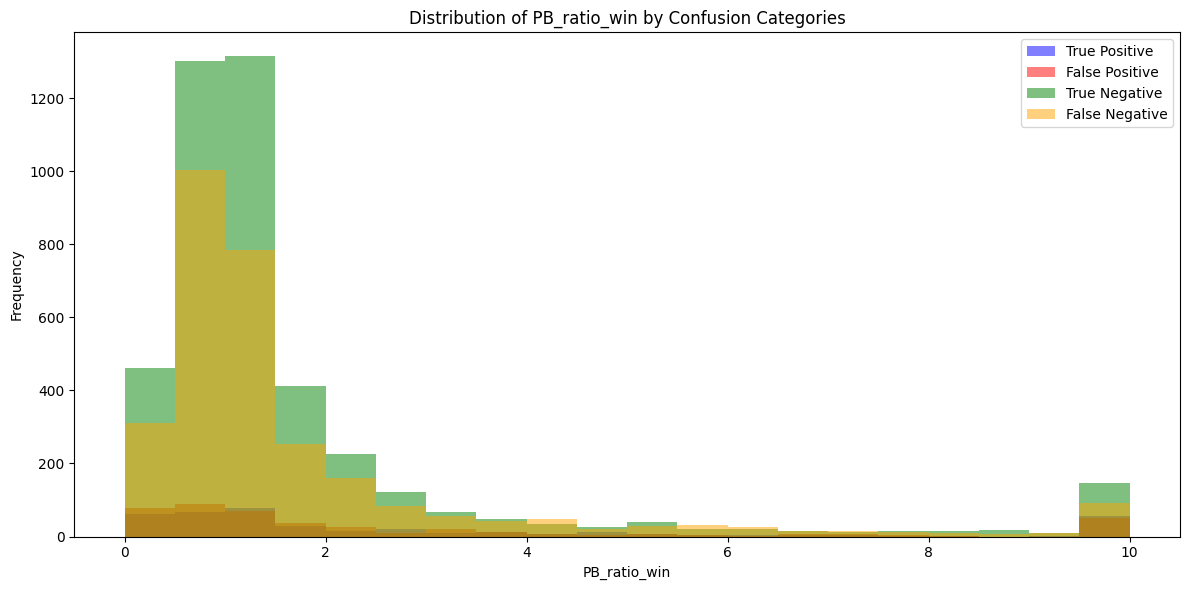


Feature: epsdiluted_lag4_win

True Positives Stats:
count    398.000000
mean       0.644437
std        1.014626
min        0.000000
25%        0.050100
50%        0.305000
75%        0.777500
max       11.820000
Name: epsdiluted_lag4_win, dtype: float64

False Positives Stats:
count    436.000000
mean       0.664412
std        1.563358
min        0.000000
25%        0.000000
50%        0.295000
75%        0.800000
max       20.000000
Name: epsdiluted_lag4_win, dtype: float64

True Negatives Stats:
count    4327.000000
mean        1.665922
std         3.280575
min         0.000000
25%         0.380000
50%         0.730000
75%         1.425000
max        20.000000
Name: epsdiluted_lag4_win, dtype: float64

False Negatives Stats:
count    3011.000000
mean        1.478170
std         2.938214
min         0.000000
25%         0.390000
50%         0.720000
75%         1.320000
max        20.000000
Name: epsdiluted_lag4_win, dtype: float64


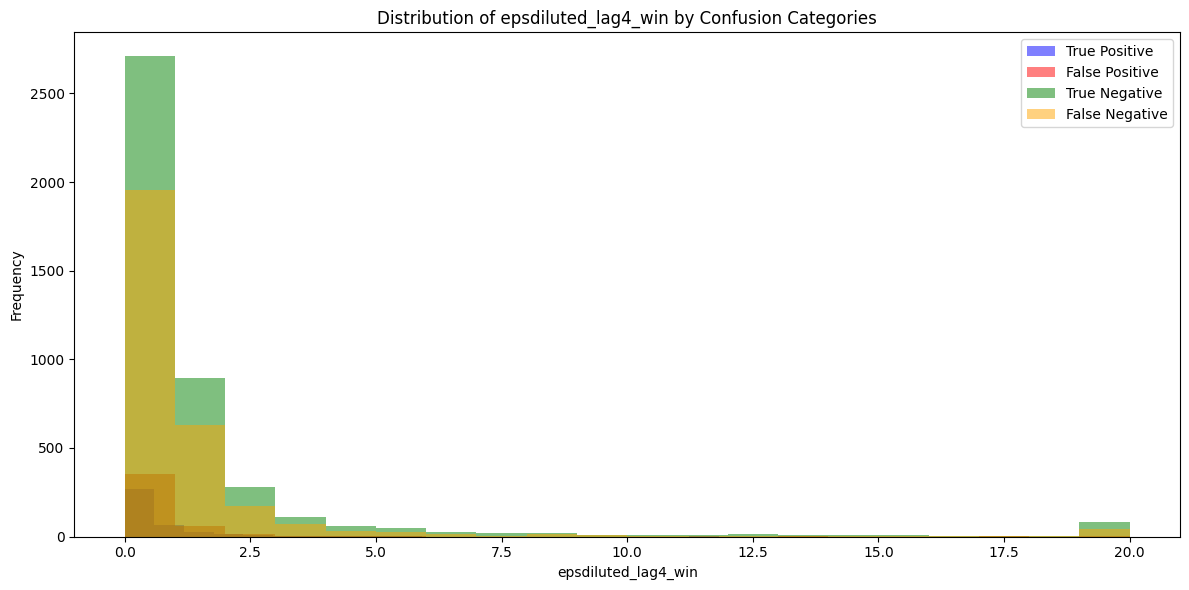


Feature: cash_ratio_win

True Positives Stats:
count    398.000000
mean       3.474120
std        6.441654
min        0.000000
25%        0.064988
50%        0.506052
75%        2.117235
max       20.000000
Name: cash_ratio_win, dtype: float64

False Positives Stats:
count    436.000000
mean       3.091758
std        6.053722
min        0.000000
25%        0.052578
50%        0.216587
75%        1.851351
max       20.000000
Name: cash_ratio_win, dtype: float64

True Negatives Stats:
count    4327.000000
mean        8.368362
std         8.357228
min         0.000000
25%         0.766769
50%         4.014247
75%        20.000000
max        20.000000
Name: cash_ratio_win, dtype: float64

False Negatives Stats:
count    3011.000000
mean        7.941584
std         8.307778
min         0.000000
25%         0.692576
50%         3.347878
75%        20.000000
max        20.000000
Name: cash_ratio_win, dtype: float64


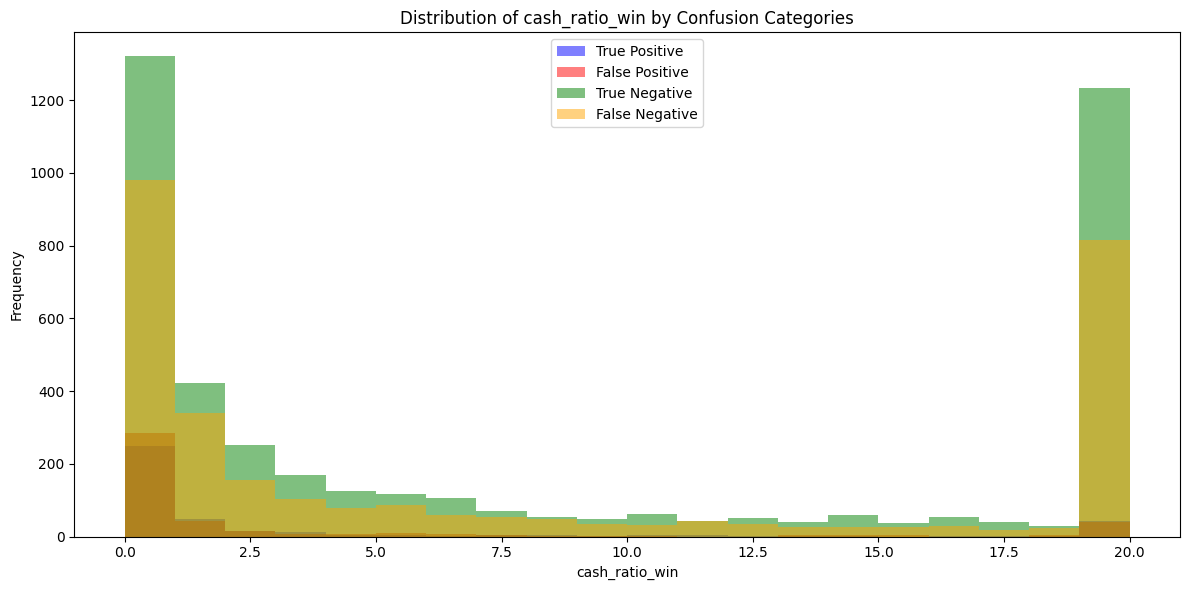


Feature: totalInvestments_to_assets_win

True Positives Stats:
count    398.000000
mean       0.272079
std        0.301183
min        0.000000
25%        0.012235
50%        0.135254
75%        0.482591
max        0.865164
Name: totalInvestments_to_assets_win, dtype: float64

False Positives Stats:
count    436.000000
mean       0.282904
std        0.296236
min        0.000000
25%        0.018738
50%        0.172859
75%        0.490297
max        0.865164
Name: totalInvestments_to_assets_win, dtype: float64

True Negatives Stats:
count    4327.000000
mean        0.395832
std         0.244089
min         0.000000
25%         0.220504
50%         0.358523
75%         0.580360
max         0.865164
Name: totalInvestments_to_assets_win, dtype: float64

False Negatives Stats:
count    3011.000000
mean        0.394392
std         0.258203
min         0.000000
25%         0.195830
50%         0.353506
75%         0.604871
max         0.865164
Name: totalInvestments_to_assets_win, dtype: float

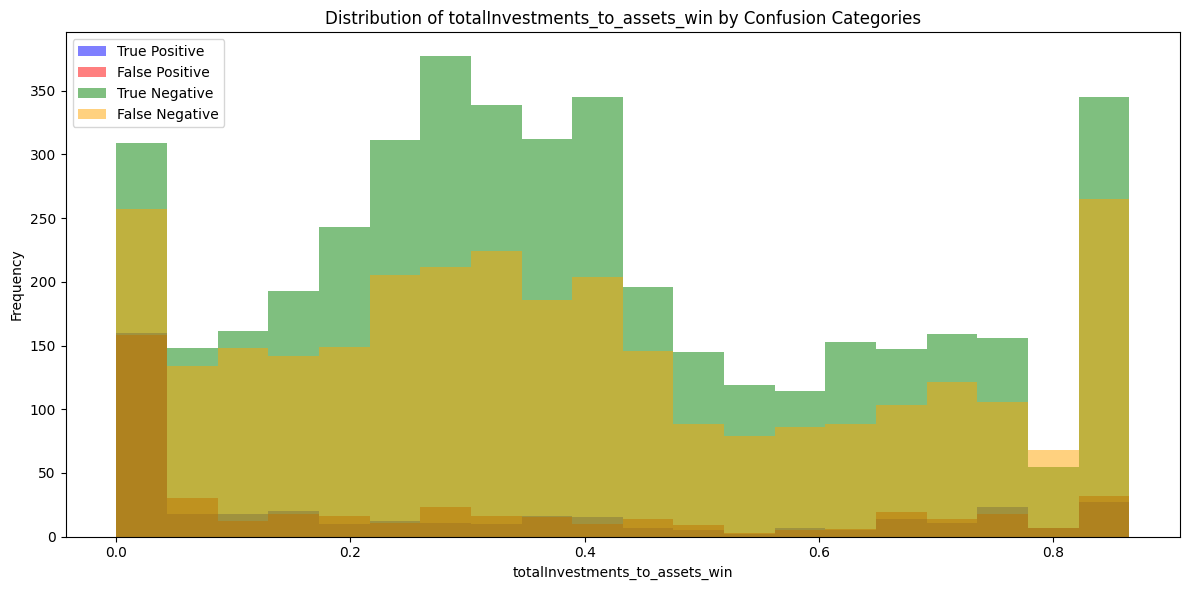


Feature: debt_ratio_win

True Positives Stats:
count    398.000000
mean       0.748252
std        0.438511
min        0.002558
25%        0.619512
50%        0.742833
75%        0.863527
max        7.788975
Name: debt_ratio_win, dtype: float64

False Positives Stats:
count    436.000000
mean       0.747692
std        0.512135
min        0.001139
25%        0.609921
50%        0.767825
75%        0.882564
max        7.587089
Name: debt_ratio_win, dtype: float64

True Negatives Stats:
count    4327.000000
mean        0.764892
std         0.227223
min         0.000607
25%         0.694380
50%         0.870368
75%         0.901824
max         1.741634
Name: debt_ratio_win, dtype: float64

False Negatives Stats:
count    3011.000000
mean        0.764502
std         0.581285
min         0.000180
25%         0.655774
50%         0.861308
75%         0.898488
max        23.914099
Name: debt_ratio_win, dtype: float64


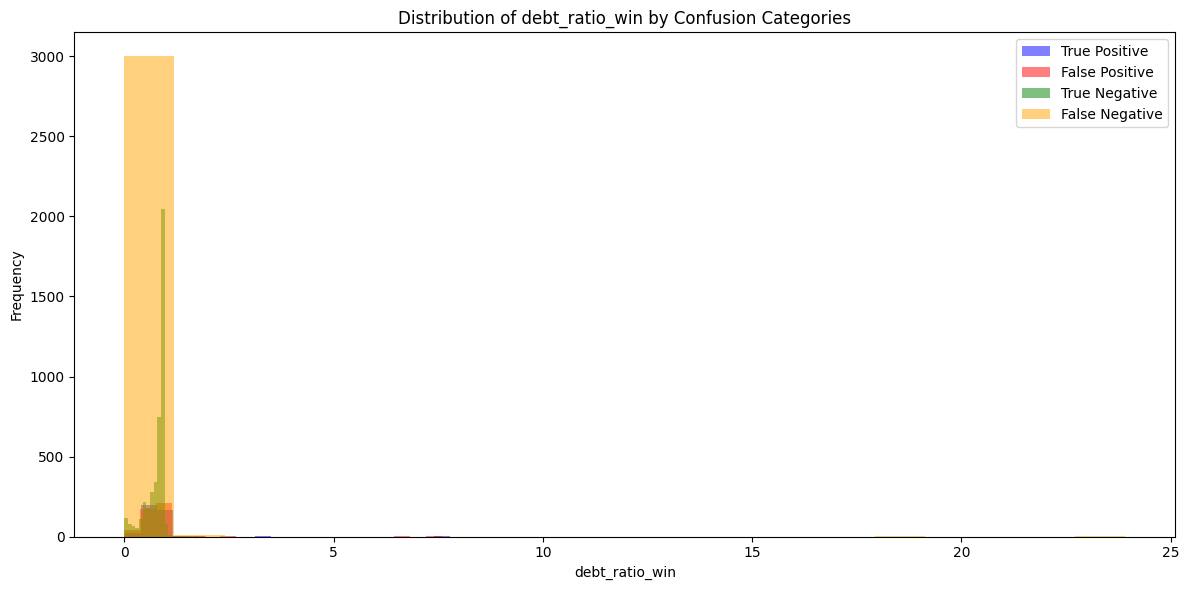

In [17]:
# Assign confusion matrix categories to test_df
def assign_confusion_categories(df: pd.DataFrame) -> pd.DataFrame:
    """
    Assigns a 'category' column based on actual labels (good_stock) and 
    predicted signals (predicted_signal):
      - "True Positive": good_stock == 1 and predicted_signal == 1
      - "False Positive": good_stock == 0 but predicted_signal == 1
      - "True Negative": good_stock == 0 and predicted_signal == 0
      - "False Negative": good_stock == 1 but predicted_signal == 0
    """
    df = df.copy()
    df['category'] = np.where(
        (df['good_stock'] == 1) & (df['predicted_signal'] == 1), 'True Positive',
        np.where(
            (df['good_stock'] == 0) & (df['predicted_signal'] == 1), 'False Positive',
            np.where(
                (df['good_stock'] == 0) & (df['predicted_signal'] == 0), 'True Negative',
                np.where(
                    (df['good_stock'] == 1) & (df['predicted_signal'] == 0), 'False Negative',
                    'Unknown'
                )
            )
        )
    )
    return df

if 'category' not in test_df.columns:
    test_df = assign_confusion_categories(test_df)


tp_df = test_df[test_df['category'] == 'True Positive']
fp_df = test_df[test_df['category'] == 'False Positive']
tn_df = test_df[test_df['category'] == 'True Negative']
fn_df = test_df[test_df['category'] == 'False Negative']

plt.figure(figsize=(12, 6))
bins = 20

# Evaluate features across all groups
features_to_evaluate = [
    'relative_log_return', 'ROE_win', 'ROA_win', 'revenue_growth_quarterly_win', 'PB_ratio_win',
    'epsdiluted_lag4_win', 'cash_ratio_win', 'totalInvestments_to_assets_win',
    'debt_ratio_win'
]

# Loop through each feature and print descriptive stats and plot histogram overlays for all groups
for feature in features_to_evaluate:
    if feature in test_df.columns:
        print(f"\nFeature: {feature}")
        print("\nTrue Positives Stats:")
        print(tp_df[feature].describe())
        print("\nFalse Positives Stats:")
        print(fp_df[feature].describe())
        print("\nTrue Negatives Stats:")
        print(tn_df[feature].describe())
        print("\nFalse Negatives Stats:")
        print(fn_df[feature].describe())
        
        # Plot overlapping histograms
        plt.figure(figsize=(12, 6))
        plt.hist(tp_df[feature].dropna(), bins=bins, alpha=0.5, label='True Positive', color='blue')
        plt.hist(fp_df[feature].dropna(), bins=bins, alpha=0.5, label='False Positive', color='red')
        plt.hist(tn_df[feature].dropna(), bins=bins, alpha=0.5, label='True Negative', color='green')
        plt.hist(fn_df[feature].dropna(), bins=bins, alpha=0.5, label='False Negative', color='orange')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {feature} by Confusion Categories')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature '{feature}' not found in test_df.")


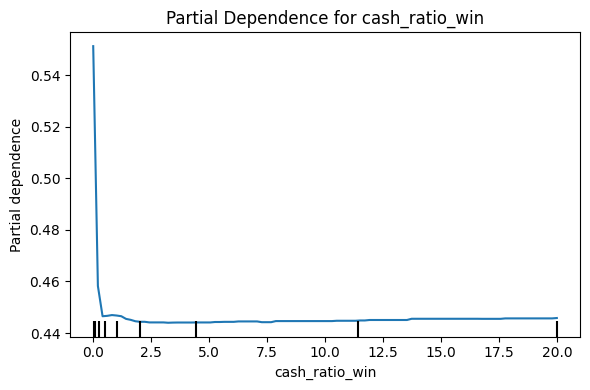

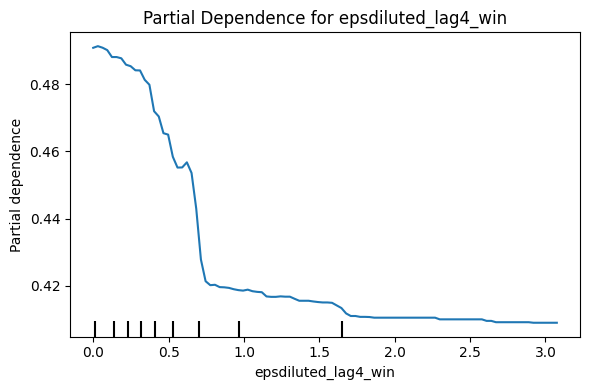

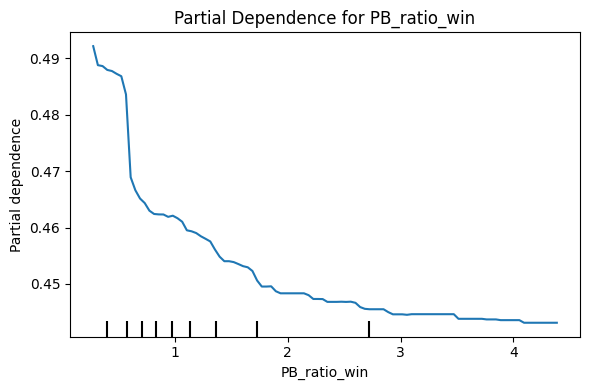

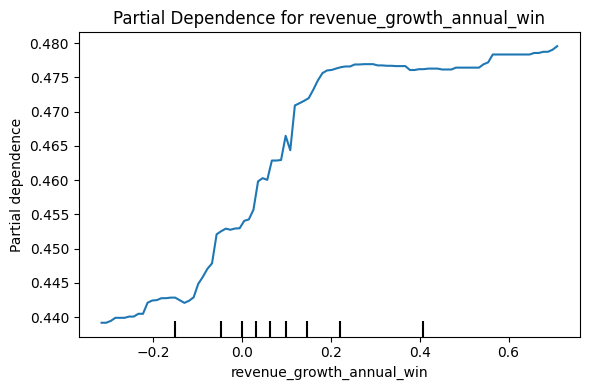

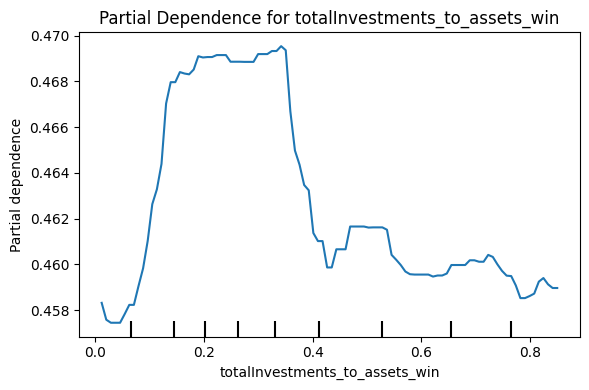

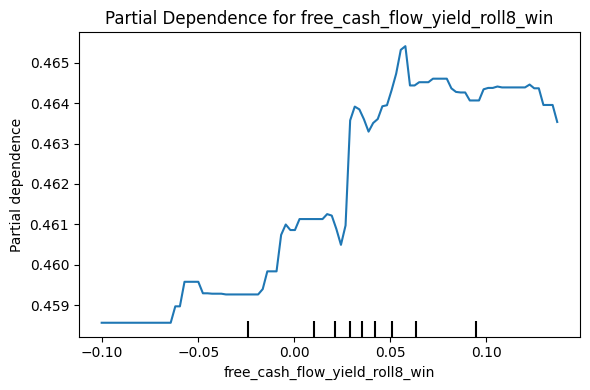

In [10]:
# Using a Partial Dependence Plot to see the marginal effect of a feature on the predicted outcome of the model.
# It shows how the predicted response, in isolation, is influenced by the chosen feature.
# We can see that a higher lagged EPS might correlate with a lower probability of outperforming the SP500. 
# We can interpret as "high EPS in the past" might leave little room or value to grow. 
# Looking for "great companies at a fair value".
# Lower P/B ratio is interpreted as "value" aka undervalued stocks. The PDP for P/B ratio shows that 
# higher P/B ratios are associated with a lower chance of having a good relative return.
features_to_plot = ['cash_ratio_win', 'epsdiluted_lag4_win', 'PB_ratio_win', 
                    'revenue_growth_annual_win', 'totalInvestments_to_assets_win', 'free_cash_flow_yield_roll8_win',]

for feature in features_to_plot:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        best_rf_model,
        X_train,
        features=[feature],
        ax=ax
    )
    plt.title(f"Partial Dependence for {feature}")
    plt.tight_layout()
    plt.show()


Bootstrap Analysis on Annualized Return:
Mean Annualized Return (bootstrap): 20.91%
95% Confidence Interval: [5.60%, 36.87%]
P-value for annualized return = 0: 0.0062


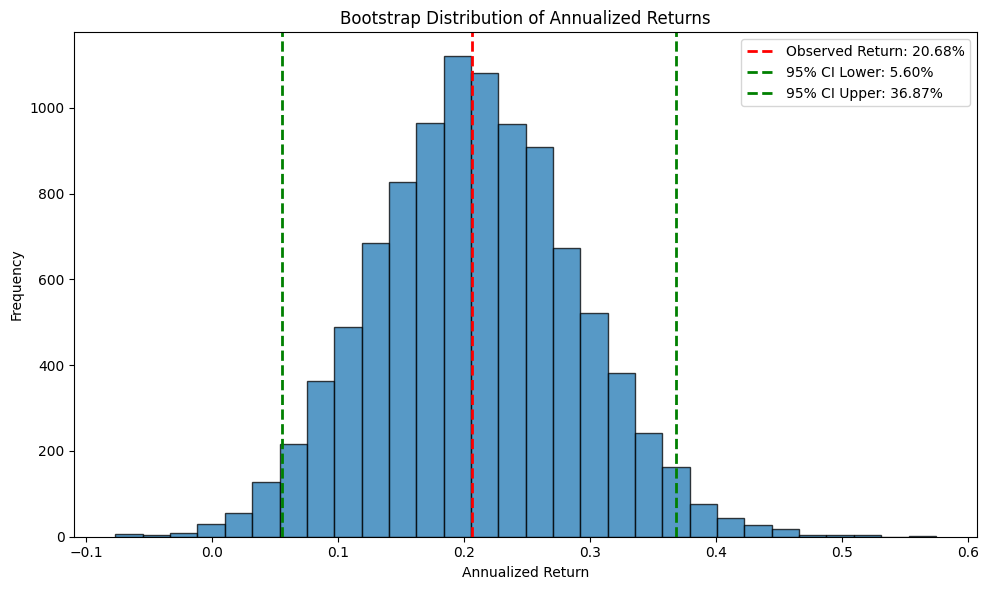

In [ ]:
# Implementing bootstrapping, a resampling technique which can be used to approx. the sampling distribution
# of a statistic (in this case, the quarterly returns) by repeatedly drawing samples from the data with replacement.
n_iterations = 10000 
bootstrap_annualized_returns = []
quarterly_returns_array = quarterly_trade_returns.values

for i in range(n_iterations):
    # Resample quarterly returns with replacement
    bootstrap_sample = np.random.choice(quarterly_returns_array, size=len(quarterly_returns_array), replace=True)
    cumulative_return_boot = np.prod(1 + bootstrap_sample)
    annualized_return_boot = cumulative_return_boot**(4/len(bootstrap_sample)) - 1
    bootstrap_annualized_returns.append(annualized_return_boot)

bootstrap_annualized_returns = np.array(bootstrap_annualized_returns)
ci_lower = np.percentile(bootstrap_annualized_returns, 2.5)
ci_upper = np.percentile(bootstrap_annualized_returns, 97.5)

if observed_annualized_return >= 0:
    p_value = 2 * np.mean(bootstrap_annualized_returns <= 0)
else:
    p_value = 2 * np.mean(bootstrap_annualized_returns >= 0)
p_value = min(p_value, 1.0)

print("\nBootstrap Analysis on Annualized Return:")
print(f"Mean Annualized Return (bootstrap): {np.mean(bootstrap_annualized_returns):.2%}")
print(f"95% Confidence Interval: [{ci_lower:.2%}, {ci_upper:.2%}]")
print(f"P-value for annualized return = 0: {p_value:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(bootstrap_annualized_returns, bins=30, alpha=0.75, edgecolor='black')
plt.axvline(observed_annualized_return, color='red', linestyle='dashed', linewidth=2, 
            label=f'Observed Return: {observed_annualized_return:.2%}')
plt.axvline(ci_lower, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Lower: {ci_lower:.2%}')
plt.axvline(ci_upper, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Upper: {ci_upper:.2%}')
plt.title("Bootstrap Distribution of Annualized Returns")
plt.xlabel("Annualized Return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


[Hierarchical (Block Bootstrap) Annualized Return Analysis:
Mean Annualized Return (bootstrap): 21.10%
95% Confidence Interval: [5.74%, 36.93%]
P-value for annualized return = 0: 0.0061


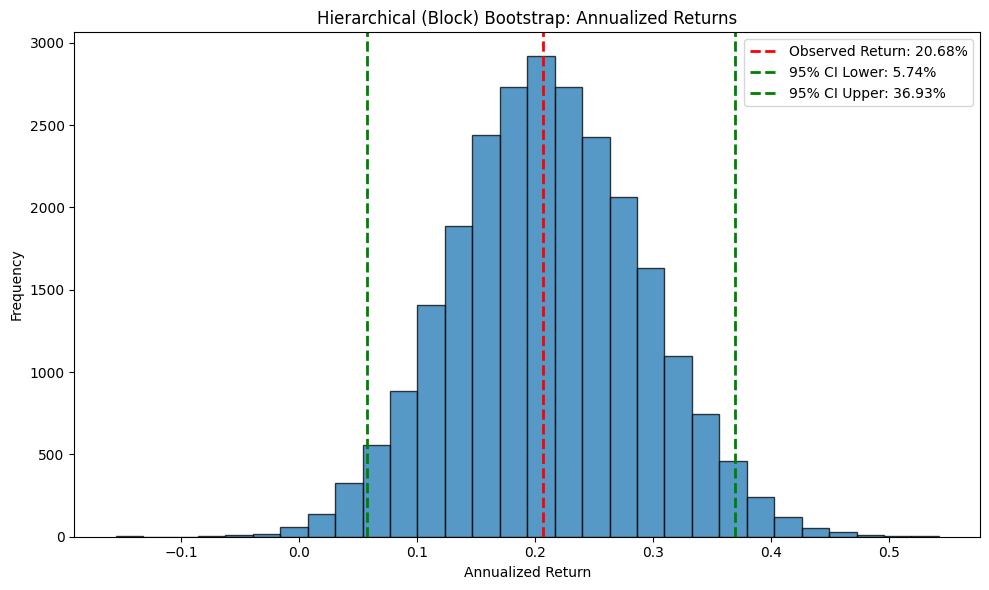

In [ ]:
# The bootstrapping above uses the quarterly returns. This is somewhat of an issue because there is only around 29 quarters to
# select from. To bootstrap in a different way, we resample at the trade level for each quarter, aggregate to the quarterly level
# and then bootstrap again. It accounts for variability within a quarter and between quarters, while also enabling use of the trades
# to sample from. This method is called Hierarchical, or Block, Bootstrapping.
def bootstrap_quarterly_return(trades_in_quarter, n_bootstrap=1000):
    """
    For a given quarter (DataFrame of trades), perform an inner bootstrap 
    to compute an aggregated quarterly return (here using the mean return).
    """
    boot_returns = []
    trade_returns = trades_in_quarter['trade_return'].values
    n_trades = len(trade_returns)
    for _ in range(n_bootstrap):
        # Resample trades for this quarter with replacement
        boot_sample = np.random.choice(trade_returns, size=n_trades, replace=True)
        boot_returns.append(np.mean(boot_sample))
    return np.mean(boot_returns)

# Get all unique quarters from trades_df
quarters = trades_df['Quarter'].unique()

# Bootstrap the quarterly return for each quarter using trade-level data
bootstrapped_quarterly_returns = {}
n_inner_bootstrap = 2000  # inner bootstrap iterations per quarter

for q in quarters:
    trades_q = trades_df[trades_df['Quarter'] == q]
    bootstrapped_quarterly_returns[str(q)] = bootstrap_quarterly_return(trades_q, n_bootstrap=n_inner_bootstrap)

boot_quarterly_returns = pd.Series(bootstrapped_quarterly_returns)
# Use the full quarter index from the simulation (all_quarters was defined earlier)
boot_quarterly_returns = boot_quarterly_returns.reindex(all_quarters.astype(str), fill_value=-0.01)

# Perform an outer bootstrap on the aggregated quarterly returns
n_outer_bootstrap = 25000
bootstrap_annualized_returns_hier = []
quarterly_returns_array = boot_quarterly_returns.values

for i in range(n_outer_bootstrap):
    # Resample the quarterly blocks - each block being a bootstrapped quarterly return)
    bootstrap_sample = np.random.choice(quarterly_returns_array, size=len(quarterly_returns_array), replace=True)
    cumulative_return = np.prod(1 + bootstrap_sample)
    annualized_return = cumulative_return**(4 / len(bootstrap_sample)) - 1
    bootstrap_annualized_returns_hier.append(annualized_return)

bootstrap_annualized_returns_hier = np.array(bootstrap_annualized_returns_hier)
ci_lower_hier = np.percentile(bootstrap_annualized_returns_hier, 2.5)
ci_upper_hier = np.percentile(bootstrap_annualized_returns_hier, 97.5)

if observed_annualized_return >= 0:
    p_value_hier = 2 * np.mean(bootstrap_annualized_returns_hier <= 0)
else:
    p_value_hier = 2 * np.mean(bootstrap_annualized_returns_hier >= 0)
p_value_hier = min(p_value_hier, 1.0)

print("\n[Hierarchical (Block Bootstrap) Annualized Return Analysis:")
print(f"Mean Annualized Return (bootstrap): {np.mean(bootstrap_annualized_returns_hier):.2%}")
print(f"95% Confidence Interval: [{ci_lower_hier:.2%}, {ci_upper_hier:.2%}]")
print(f"P-value for annualized return = 0: {p_value_hier:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(bootstrap_annualized_returns_hier, bins=30, alpha=0.75, edgecolor='black')
plt.axvline(observed_annualized_return, color='red', linestyle='dashed', linewidth=2, 
            label=f'Observed Return: {observed_annualized_return:.2%}')
plt.axvline(ci_lower_hier, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Lower: {ci_lower_hier:.2%}')
plt.axvline(ci_upper_hier, color='green', linestyle='dashed', linewidth=2, 
            label=f'95% CI Upper: {ci_upper_hier:.2%}')
plt.title("Hierarchical (Block) Bootstrap: Annualized Returns")
plt.xlabel("Annualized Return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


No-Predictability Benchmark Performance (Random Signals):
Quarterly Trade Returns:
 2016Q1   -0.010000
2016Q2    0.147145
2016Q3    0.047543
2016Q4    0.068942
2017Q1    0.221172
2017Q2   -0.031997
2017Q3    0.029551
2017Q4    0.072617
2018Q1    0.025600
2018Q2   -0.054637
2018Q3    0.014612
2018Q4   -0.061486
2019Q1   -0.007653
2019Q2    0.014623
2019Q3    0.003997
2019Q4    0.000363
2020Q1   -0.016031
2020Q2   -0.172977
2020Q3    0.128953
2020Q4    0.095184
2021Q1    1.041789
2021Q2    0.120160
2021Q3    0.364069
2021Q4    0.104507
2022Q1    0.034191
2022Q2   -0.101974
2022Q3   -0.009698
2022Q4   -0.019551
2023Q1   -0.002662
Freq: Q-DEC, Name: trade_return, dtype: float64
Cumulative Portfolio Returns:
 2016Q1    0.990000
2016Q2    1.135674
2016Q3    1.189667
2016Q4    1.271685
2017Q1    1.552947
2017Q2    1.503257
2017Q3    1.547679
2017Q4    1.660067
2018Q1    1.702565
2018Q2    1.609541
2018Q3    1.633061
2018Q4    1.532650
2019Q1    1.520920
2019Q2    1.543161
2019Q3    1.549329


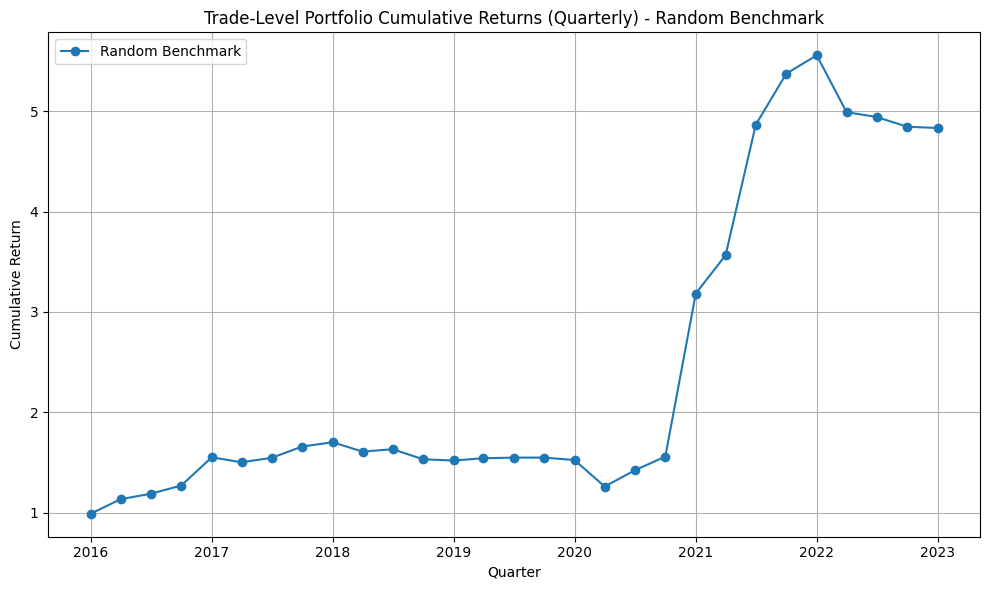

In [ ]:
# No-Predictability (Random Signal) Benchmark
# Generate random signals that preserve the same positive rate (%) as the model's predictions.
# This ensures the overall frequency of trades is similar to the model.

# Calculate the positive rate from the model predictions
p_rate = test_sim['predicted_signal'].mean()
np.random.seed(42)

# Create a new random signal column using a Bernoulli process with probability p_rate, and then use the random signal for 
# simulation by copying test_sim and replacing the predicted_signal
test_sim['random_signal'] = np.random.binomial(1, p_rate, size=len(test_sim))

test_sim_random = test_sim.copy()
test_sim_random['predicted_signal'] = test_sim_random['random_signal']

# Run simulation
all_trades_random = []
for symbol, group in test_sim_random.groupby('symbol_stock'):
    trades = simulate_trades_for_stock_enhanced(
        group,
        transaction_cost,
        slippage,
        stop_loss=-0.1,
        take_profit=0.10,
        max_hold_periods=6,
        risk_per_trade=1000,
        account_balance=100000
    )
    all_trades_random.extend(trades)

trades_df_random = pd.DataFrame(all_trades_random)

if trades_df_random.empty:
    print("No trades were simulated for the random benchmark.")
else:
    # Create a quarterly time period for aggregation
    trades_df_random['entry_date'] = pd.to_datetime(trades_df_random['entry_date'])
    trades_df_random['exit_date'] = pd.to_datetime(trades_df_random['exit_date'])
    trades_df_random['Quarter'] = trades_df_random['exit_date'].dt.to_period('Q')

    # Aggregate quarterly trade returns (using mean return per quarter)
    quarterly_trade_returns_random = trades_df_random.groupby('Quarter')['trade_return'].mean()

    all_quarters = pd.period_range(
        start=test_sim['accepted_date'].min().to_period('Q'),
        end=test_sim['accepted_date'].max().to_period('Q'),
        freq='Q'
    )
    quarterly_trade_returns_random = quarterly_trade_returns_random.reindex(all_quarters, fill_value=-0.01)

    # Compute cumulative portfolio returns from quarterly returns
    cumulative_returns_random = (1 + quarterly_trade_returns_random).cumprod()
    n_quarters_random = len(cumulative_returns_random)
    observed_annualized_return_random = (cumulative_returns_random.iloc[-1])**(4/n_quarters_random) - 1
    sharpe_ratio_random = (quarterly_trade_returns_random.mean() /
                           quarterly_trade_returns_random.std()) * np.sqrt(4)
    peak_random = cumulative_returns_random.cummax()
    drawdown_random = (cumulative_returns_random - peak_random) / peak_random
    max_drawdown_random = drawdown_random.min()

    print("\nNo-Predictability Benchmark Performance (Random Signals):")
    print("Quarterly Trade Returns:\n", quarterly_trade_returns_random)
    print("Cumulative Portfolio Returns:\n", cumulative_returns_random)
    print(f"Observed Annualized Return: {observed_annualized_return_random:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio_random:.2f}")
    print(f"Maximum Drawdown: {max_drawdown_random:.2%}")

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns_random.index.to_timestamp(), cumulative_returns_random,
             marker='o', label='Random Benchmark')
    plt.title("Trade-Level Portfolio Cumulative Returns (Quarterly) - Random Benchmark")
    plt.xlabel("Quarter")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

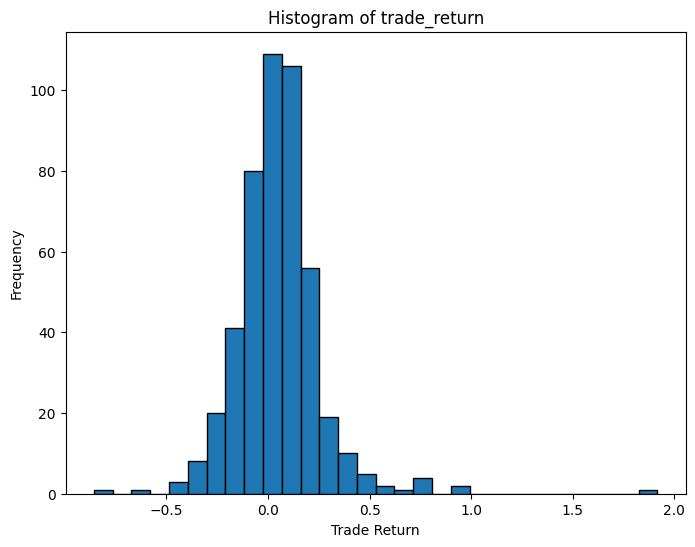

In [55]:
plt.figure(figsize=(8, 6))
plt.hist(trades_df['trade_return'], bins=30, edgecolor='black')
plt.title('Histogram of trade_return')
# plt.xlim(-1, 5)
plt.xticks()
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.show()